import necessary libraries

In [23]:
import pandas as pd
import numpy as np
import re
import string
from google.colab import files
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Upload the File

In [4]:
print("Labelled_real_and_Fake_Dataset.csv")
uploaded = files.upload()
df = pd.read_csv("Labelled_real_and_Fake_Dataset.csv")

Labelled_real_and_Fake_Dataset.csv


Saving Labelled_real_and_Fake_Dataset.csv to Labelled_real_and_Fake_Dataset.csv


Handling Missing Data



In [5]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


Filling or Removing Duplicates

In [6]:
# Drop duplicate rows based on 'title' and 'text'
df.drop_duplicates(subset=['title', 'text'], inplace=True)



 Standardize Text Format

In [7]:
# Convert to lowercase, remove numbers and punctuation
def standardize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text


Tokenization & Lemmatization using NLTK

In [8]:
# Define function for full text cleaning
def preprocess_text(text):
    text = standardize_text(text)  # Step 3
    words = text.strip().split()  # Tokenize
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.isalpha() and word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatize
    return ' '.join(words)


Preprocessing

In [9]:
# Apply preprocessing to the 'text' column and create a new 'cleaned_text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Optional: Apply preprocessing to the 'title' column (if needed)
df['cleaned_title'] = df['title'].apply(preprocess_text)

# Preview the result (show the original 'title' and the 'cleaned_text' columns)
df[['title', 'cleaned_text']].head()


,title,cleaned_text
0,You Can Smell Hillary’s Fear,daniel greenfield shillman journalism fellow f...
1,Watch The Exact Moment Paul Ryan Committed Pol...,google pinterest digg linkedin reddit stumbleu...
2,Kerry to go to Paris in gesture of sympathy,u secretary state john f kerry said monday sto...
3,Bernie supporters on Twitter erupt in anger ag...,kaydee king kaydeeking november lesson tonight...
4,The Battle of New York: Why This Primary Matters,primary day new york frontrunners hillary clin...


 Exploratory Data Analysis (EDA)

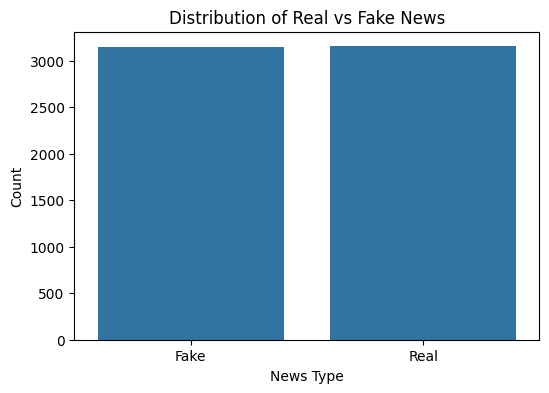

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Real vs Fake News')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.xlabel('News Type')
plt.ylabel('Count')
plt.show()


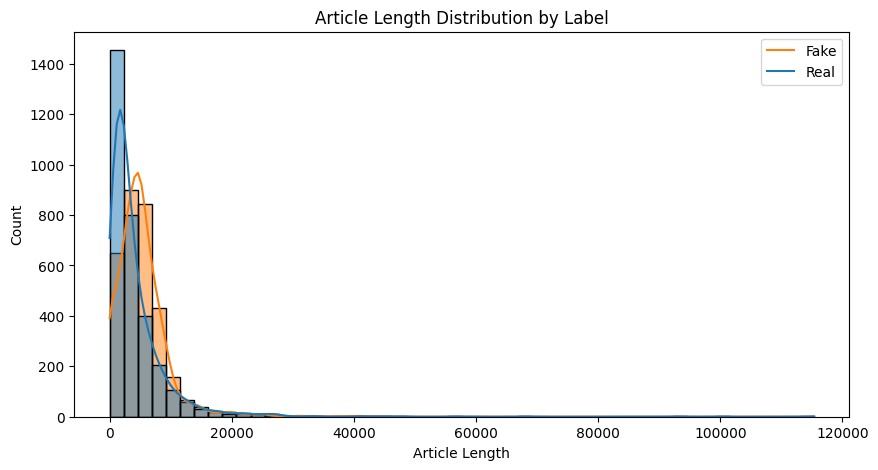

In [11]:
# Calculate article lengths and store in a new column
df['article_length'] = df['text'].apply(len)


plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='article_length', hue='label', bins=50, kde=True)
plt.title('Article Length Distribution by Label')
plt.xlabel('Article Length')
plt.ylabel('Count')
plt.legend(['Fake', 'Real'])
plt.show()


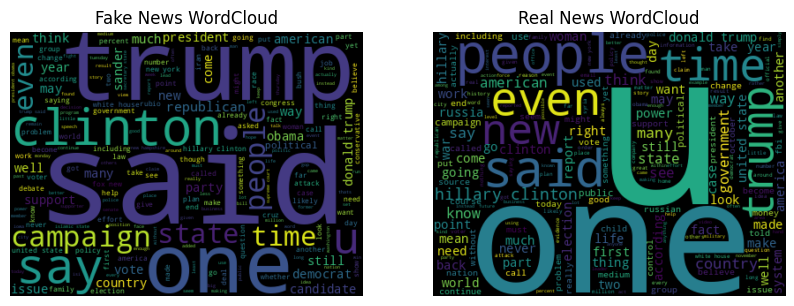

In [12]:
from wordcloud import WordCloud

# Join texts by class
fake_text = ' '.join(df[df['label'] == 'REAL']['cleaned_text'])
real_text = ' '.join(df[df['label'] == 'FAKE']['cleaned_text'])

# Generate wordclouds
wordcloud_fake = WordCloud(width=400, height=300).generate(fake_text)
wordcloud_real = WordCloud(width=400, height=300).generate(real_text)

# Plot them
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News WordCloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News WordCloud')
plt.axis('off')

plt.show()

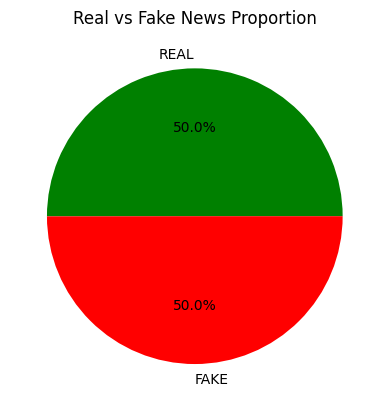

In [13]:
df['label'].value_counts().plot.pie(labels=['REAL', 'FAKE'], autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Real vs Fake News Proportion")
plt.ylabel("")
plt.show()


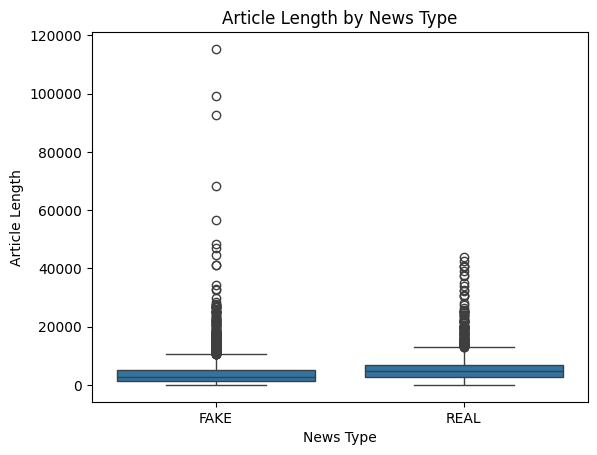

In [14]:
sns.boxplot(x='label', y='article_length', data=df)
plt.xticks([0, 1], ['FAKE', 'REAL'])
plt.title("Article Length by News Type")
plt.xlabel("News Type")
plt.ylabel("Article Length")
plt.show()


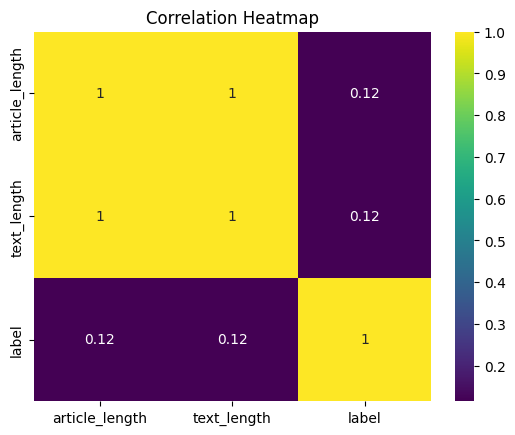

In [15]:
# Calculate article lengths and store in a new column called 'text_length'
df['text_length'] = df['text'].apply(len)

# Convert 'label' column to numerical representation (0 for FAKE, 1 for REAL)
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

sns.heatmap(df[['article_length', 'text_length', 'label']].corr(), annot=True, cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()


Text Vectorization (TF-IDF)

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine title and text if both exist
if 'title' in df.columns and 'text' in df.columns:
    df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
elif 'text' in df.columns:
    df['content'] = df['text']
elif 'title' in df.columns:
    df['content'] = df['title']
else:
    raise ValueError("No 'title' or 'text' column found in the dataset.")

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_tfidf = tfidf_vectorizer.fit_transform(df['content'])
print(X_tfidf.shape)


(6306, 67618)


 text length features

In [17]:
# Create text length features
df['title_length'] = df['title'].fillna('').apply(len)
df['text_length'] = df['text'].fillna('').apply(len)
df['content_length'] = df['content'].apply(len)
print(df[['title_length', 'text_length', 'content_length']].head())


   title_length  text_length  content_length
0            28         7518            7547
1            85         2646            2732
2            43         2543            2587
3            84         2660            2745
4            48         1840            1889


In [19]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


sentiment analysis

   label  sentiment
0      0    -0.9997
1      0     0.7723
2      1     0.9590
3      0     0.1705
4      1     0.9937

Average Sentiment Scores:
 label
0    0.038796
1    0.228752
Name: sentiment, dtype: float64


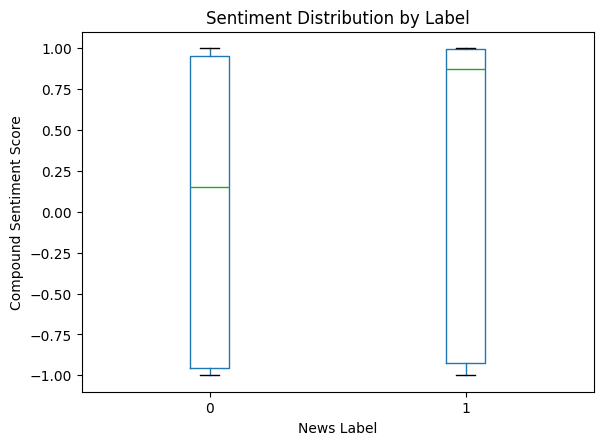

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each article's text
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])

# Show a few examples
print(df[['label', 'sentiment']].head())

# Calculate average sentiment scores for fake and real articles
avg_sentiment = df.groupby('label')['sentiment'].mean()
print("\nAverage Sentiment Scores:\n", avg_sentiment)

# Visualize sentiment distribution
df.boxplot(column='sentiment', by='label', grid=False)
plt.title('Sentiment Distribution by Label')
plt.suptitle('')
plt.xlabel('News Label')
plt.ylabel('Compound Sentiment Score')
plt.show()


In [24]:
# Create new text length-based features
df['text_length'] = df['text'].apply(len)
df['title_length'] = df['title'].apply(len)
df['num_words_text'] = df['text'].apply(lambda x: len(x.split()))
df['num_words_title'] = df['title'].apply(lambda x: len(x.split()))

# Print the updated DataFrame with new features
print(df[['text_length', 'title_length', 'num_words_text', 'num_words_title']])


      text_length  title_length  num_words_text  num_words_title
0            7518            28            1296                5
1            2646            85             446               14
2            2543            43             431                9
3            2660            84             404               15
4            1840            48             317                9
...           ...           ...             ...              ...
6330         4076            69             642               11
6331        14323            59            2183               10
6332        11974            66            1947                9
6333         6991            67            1120               11
6334         4818            61             825               10

[6306 rows x 4 columns]


In [25]:
print(df['label'].value_counts())


label
1    3154
0    3152
Name: count, dtype: int64


In [26]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])  # FAKE=0, REAL=1 (typically)


In [28]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# Assuming X_tfidf is your feature matrix and df['label'] is your target variable
X = X_tfidf
y = df['label']

# Example using oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# For undersampling (optional alternative)
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X, y)


In [29]:
import numpy as np
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(3154), np.int64(1): np.int64(3154)}


In [30]:

# 1. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42)


In [31]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       604
           1       0.94      0.90      0.92       658

    accuracy                           0.92      1262
   macro avg       0.92      0.92      0.92      1262
weighted avg       0.92      0.92      0.92      1262



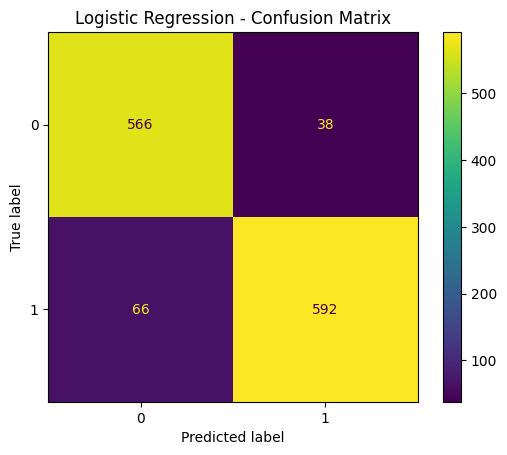


=== Naive Bayes ===
              precision    recall  f1-score   support

           0       0.97      0.75      0.84       604
           1       0.81      0.98      0.89       658

    accuracy                           0.87      1262
   macro avg       0.89      0.86      0.87      1262
weighted avg       0.89      0.87      0.87      1262



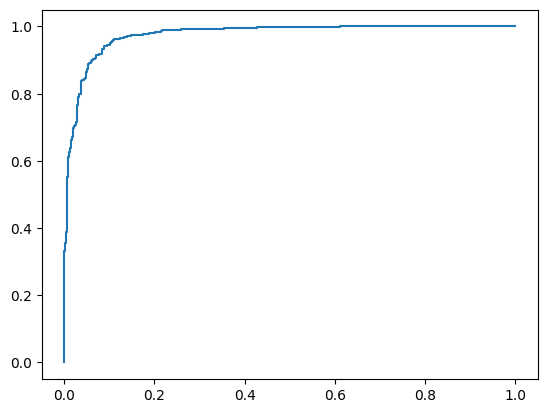

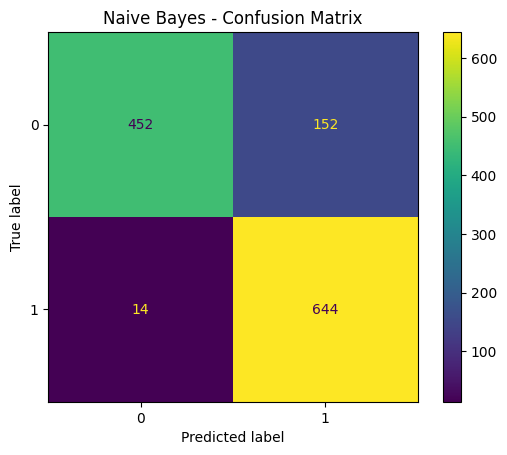


=== SVM ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       604
           1       0.95      0.92      0.93       658

    accuracy                           0.93      1262
   macro avg       0.93      0.93      0.93      1262
weighted avg       0.93      0.93      0.93      1262



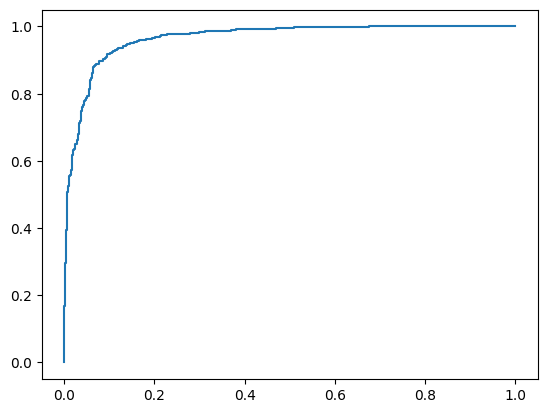

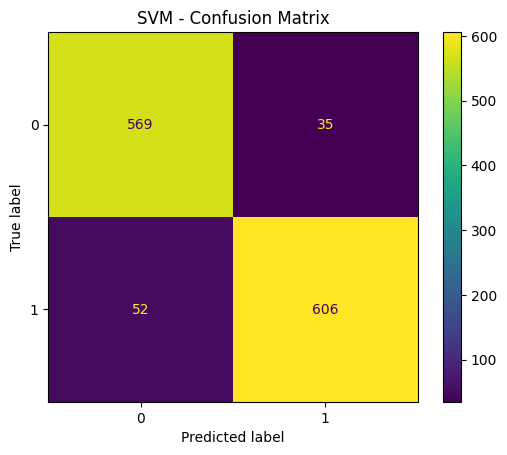


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       604
           1       0.92      0.90      0.91       658

    accuracy                           0.90      1262
   macro avg       0.90      0.90      0.90      1262
weighted avg       0.90      0.90      0.90      1262



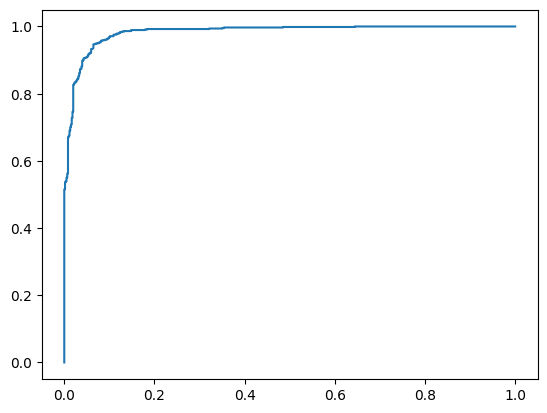

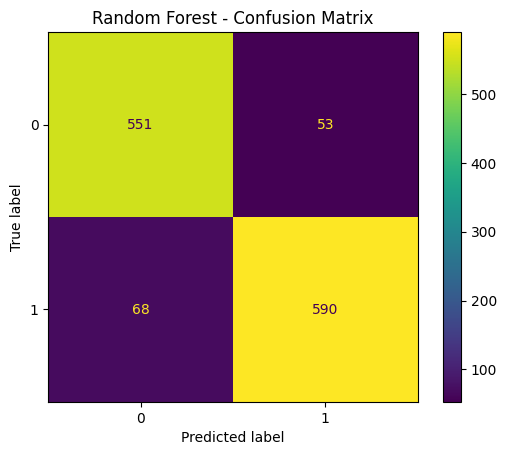


=== XGBoost ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:01:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.92      0.94      0.93       604
           1       0.94      0.92      0.93       658

    accuracy                           0.93      1262
   macro avg       0.93      0.93      0.93      1262
weighted avg       0.93      0.93      0.93      1262



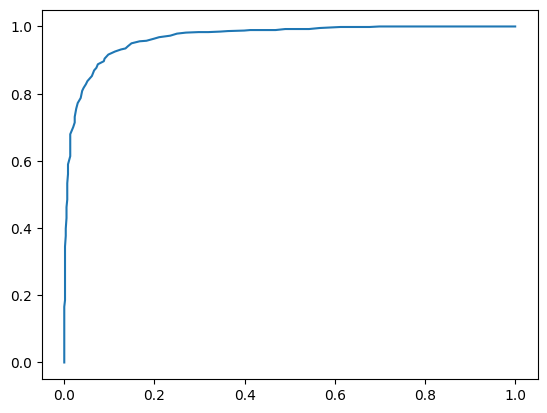

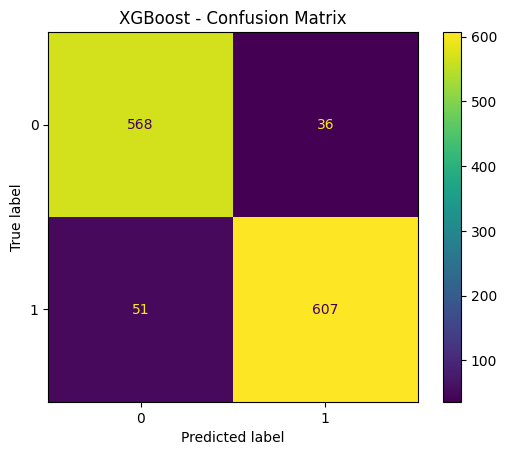

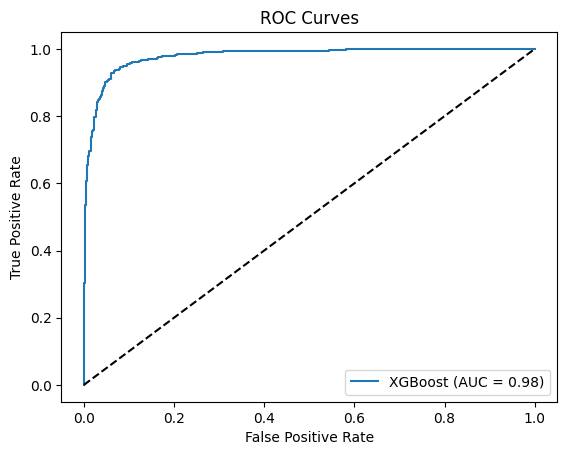

In [32]:
# 3. Train and Evaluate Models
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    # ROC Curve
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

In [35]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test) # Changed Y_test to y_test
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9310618066561014


In [37]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train) # Changed Y_train to y_train
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9984139571768438


In [39]:
print(y_test.iloc[3])  # Accessing the 4th element of y_test Series using .iloc

0


In [33]:
X_new = X_test[3]

prediction = model.predict(X_new)
print(prediction)

if (prediction[0]==0):
  print('The news is Real')
else:
  print('The news is Fake')

[0]
The news is Real
